In [1]:
#%pip install openpyxl
import pandas as pd

data = pd.read_excel('dataR2.xlsx', usecols=["Age", "BMI", "Glucose", "Insulin", "HOMA", "Leptin", "Adiponectin", "Resistin", "MCP.1", "Classification"])

print(data)

     Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  \
0     48  23.500000       70    2.707  0.467409   8.8071     9.702400   
1     83  20.690495       92    3.115  0.706897   8.8438     5.429285   
2     82  23.124670       91    4.498  1.009651  17.9393    22.432040   
3     68  21.367521       77    3.226  0.612725   9.8827     7.169560   
4     86  21.111111       92    3.549  0.805386   6.6994     4.819240   
..   ...        ...      ...      ...       ...      ...          ...   
111   45  26.850000       92    3.330  0.755688  54.6800    12.100000   
112   62  26.840000      100    4.530  1.117400  12.4500    21.420000   
113   65  32.050000       97    5.730  1.370998  61.4800    22.540000   
114   72  25.590000       82    2.820  0.570392  24.9600    33.750000   
115   86  27.180000      138   19.910  6.777364  90.2800    14.110000   

     Resistin    MCP.1  Classification  
0     7.99585  417.114               1  
1     4.06405  468.786               1  


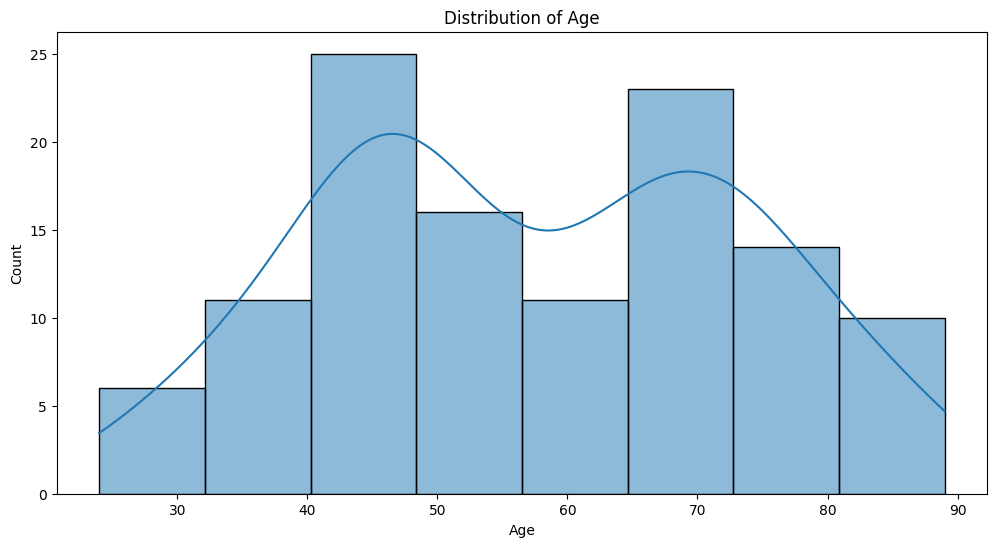

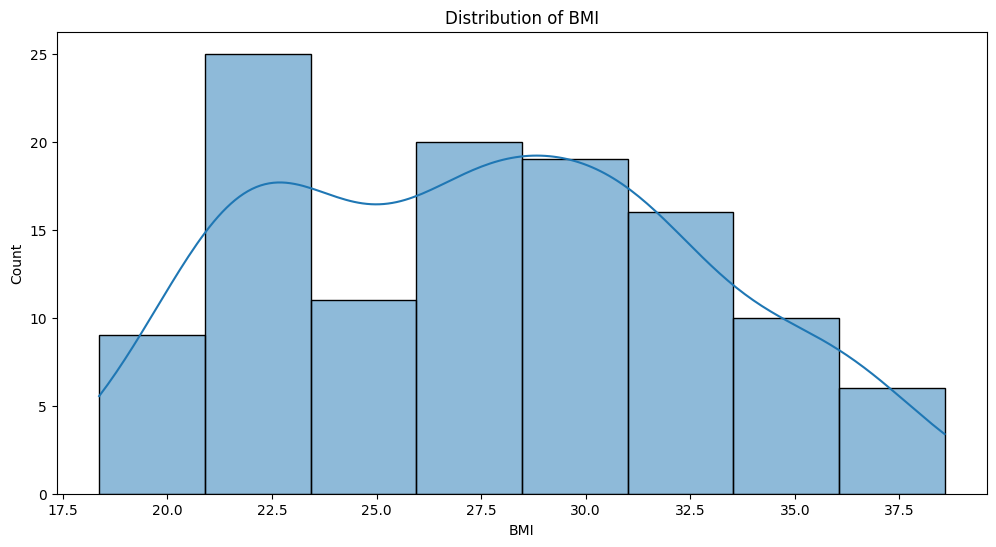

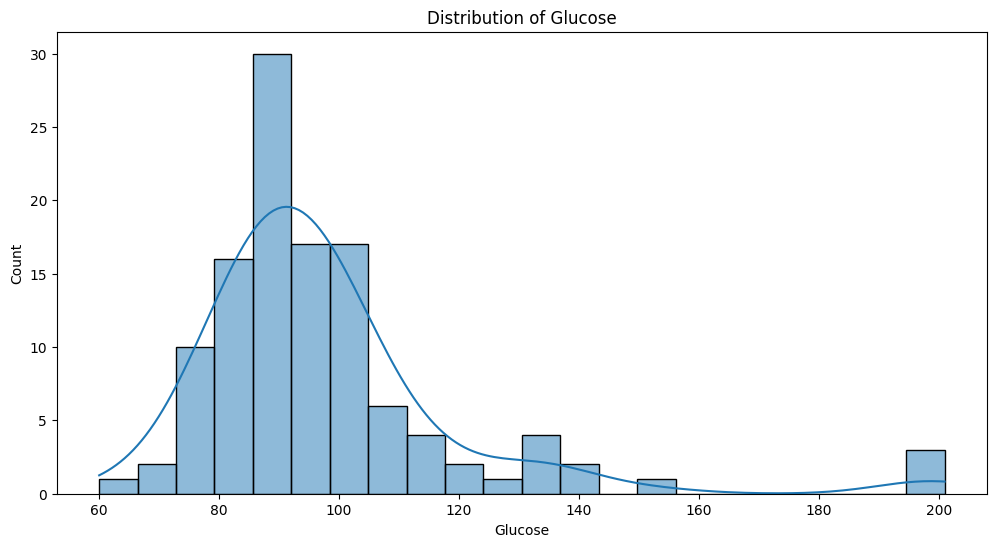

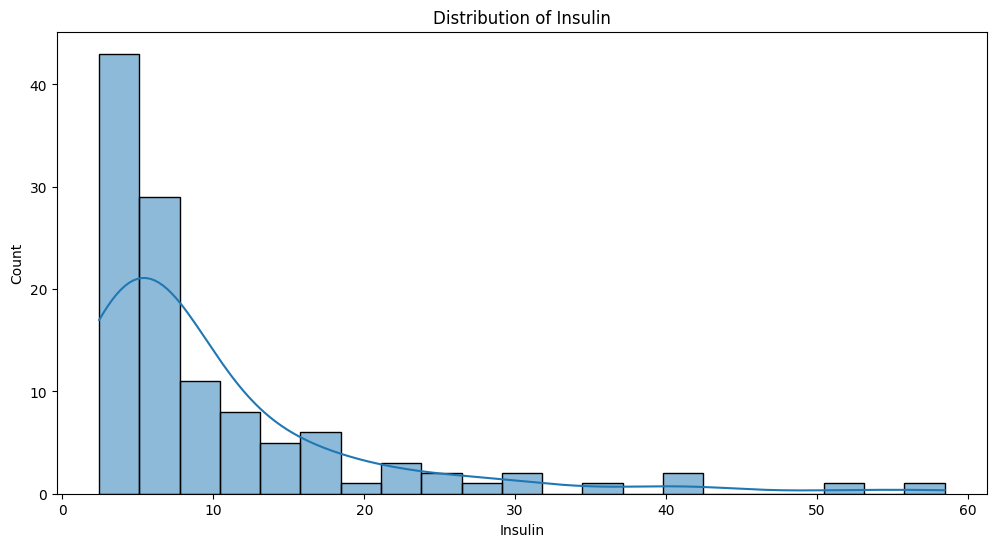

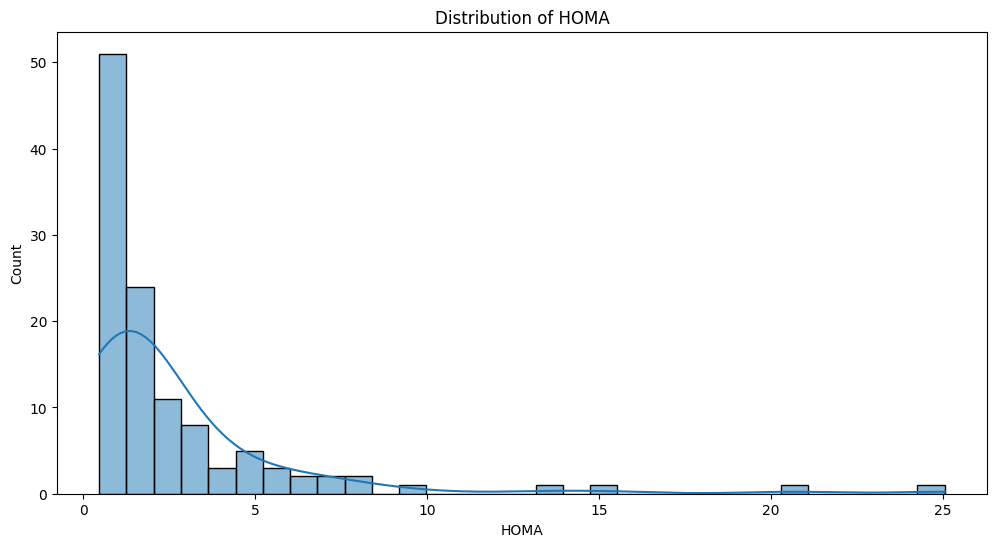

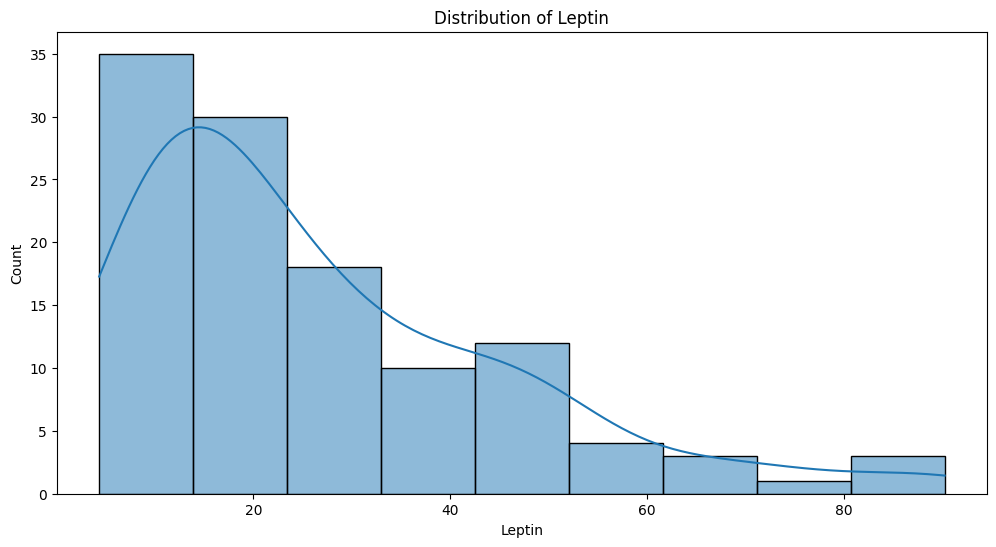

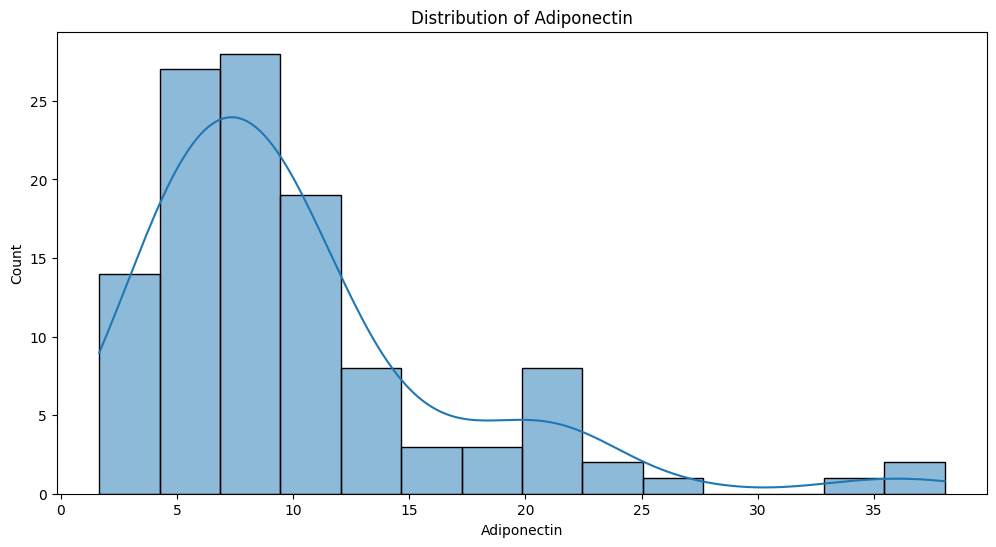

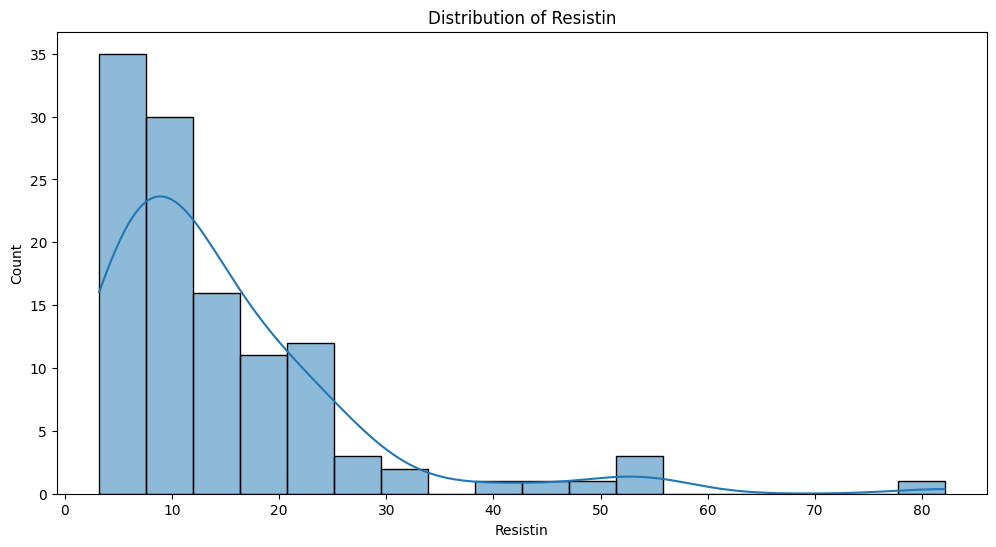

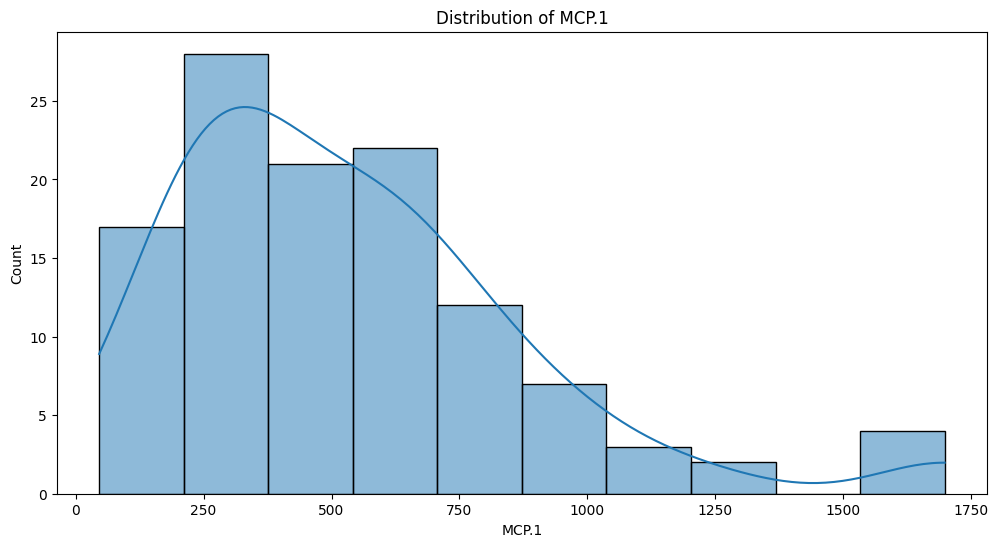

In [10]:
## A histogram allow us to view the distribution of values ​​for each variable
# and it helps to see the shape of the distribution, detect outliers or extreme values, 
# ​​and compare distributions between classes.

# %pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

columns = data.columns[:-1]  # Exclude the last column "Classification"

for column in columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [12]:
## Box plots for each variable, grouped by the "Classification" column.
import plotly.graph_objects as go

# We're labeling the classes 1 and 2 as "Has Breast Cancer" and "No Breast Cancer"
class_labels = {1: "Has Breast Cancer", 2: "No Breast Cancer"}

for column in columns:
    fig = go.Figure()
    for label in class_labels:
        fig.add_trace(go.Violin(
            y=data[data['Classification'] == label][column],
            name=class_labels[label],
            box_visible=True,
            meanline_visible=True,
            points='all'
        ))
    fig.update_layout(
        title=f'{column} by Classification',
        autosize=False,
        width=1000,
        height=500,
        font=dict(size=18, color="black")
    )
    fig.show()

# Data partioning
O particonamento dos dados permite avaliar a capacidade de generalização dos modelos e evitar o fenómeno de overfitting.
Dessa forma, a separação entre conjuntos de treino, validação e teste é importante, de modo a garantir que o modelo é avaliado utilizando apenas dados que não foram vistos durante o treino.

Devido ao reduzido número de instâncias disponíveis (116 pacientes) e ao facto de o problema consistir numa classificação binária com classes relativamente equilibradas (64 pacientes com cancro e 52 controlos saudáveis), optou-se por combinar hold-out e validação cruzada estratificada (Stratified k-Fold Cross-Validation).

Uma pequena parte do dataset (15%) é reservada como conjunto de teste final, utilizado apenas para a avaliação final do modelo, enquanto o conjunto de treino restante (85%) é submetido ao Stratified k-Fold Cross-Validation. Este método permite maximizar a utilização dos dados para treino e teste, assegurando simultaneamente que a proporção das classes é mantida em cada partição.

In [41]:
from sklearn.model_selection import train_test_split

X = data.drop('Classification', axis=1)
y = data['Classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)




In [45]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Find the indexes where de class samples are located
ixNotCancer = np.where(data["Classification"] == 1)
ixHasCancer = np.where(data["Classification"] == 2)

ixHasOrNot=np.concatenate((ixNotCancer[0],ixHasCancer[0]))
y=data['Classification'].to_numpy()[ixHasOrNot]


roc_auc=np.zeros(columns.shape)
i=0
for f in columns: #Go along features
    fpr, tpr, _= roc_curve(y,data[f].to_numpy()[ixHasOrNot],pos_label=2)
    
    figR = go.Figure()
    figR.add_scatter(x=fpr, y=tpr,mode='lines+markers')
    figR.update_layout(autosize=False,width=700,height=700,title=dict(text=f))
    figR.update_xaxes(title_text="1-SP",range=[-0.01, 1.01])
    figR.update_yaxes(title_text="SS",range=[-0.01, 1.01])
    

    roc_auc[i] = auc(fpr, tpr)#Compute area under the ROC curve
    
    figR.add_annotation(x=0.5, y=0.5,
            text="AUC: "+str(roc_auc[i]),
            showarrow=False,
            yshift=10)
    figR.show()
    i=i+1

In [43]:
from scipy import stats
import numpy as np

X = X_train.to_numpy(dtype=float)

ixHealthy = (y_train == 1).to_numpy()
ixCancer = (y_train == 2).to_numpy()

fnames = X_train.columns

Hs = []

for i in range(X.shape[1]):
    st = stats.kruskal(X[ixHealthy, i].flatten(), X[ixCancer, i].flatten())
    Hs.append((fnames[i], st.statistic, st.pvalue))

Hs = sorted(Hs, key=lambda x: x[1], reverse=True)

print("Ranked features (Kruskal-Wallis):")
for f in Hs:
    print(f"{f[0]:15} --> H = {f[1]:.4f}, p = {f[2]:.4f}")


Ranked features (Kruskal-Wallis):
Glucose         --> H = 18.1080, p = 0.0000
HOMA            --> H = 6.3437, p = 0.0118
BMI             --> H = 3.8522, p = 0.0497
Resistin        --> H = 3.1928, p = 0.0740
Insulin         --> H = 2.9106, p = 0.0880
Adiponectin     --> H = 1.5979, p = 0.2062
Leptin          --> H = 0.1995, p = 0.6551
MCP.1           --> H = 0.1445, p = 0.7038
Age             --> H = 0.1172, p = 0.7321


### Kruskall-Wallis conclusion ###
O Kruskal–Wallis H test é um método estatístico não paramétrico utilizado para verificar se existem diferenças estatisticamente significativas entre as medianas de três ou mais grupos independentes. Embora o problema em análise seja binário, optou-se por aplicar este teste, uma vez que permite identificar variáveis com potencial discriminativo entre classes, contribuindo assim para a seleção das features mais relevantes para os classificadores.

Com base nos resultados obtidos, verificou-se que as variáveis Glucose e HOMA apresentam valores elevados de H e p-values<0.05, indicando diferenças significativas entre os grupos. Estas variáveis foram, por isso, consideradas particularmente relevantes para as etapas seguintes de seleção de features e redução de dimensionalidade.

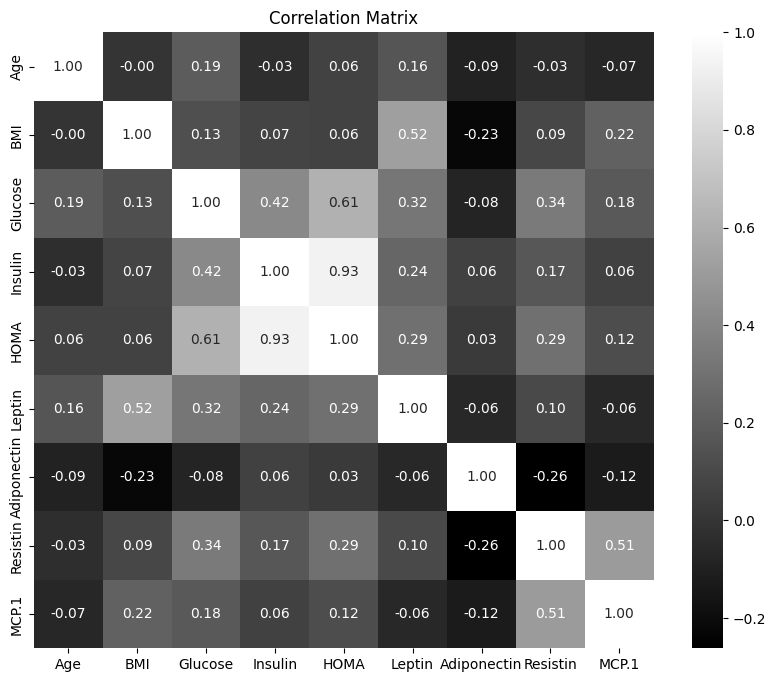

In [44]:
## Correlation matrix to see how the variables are correlated with each other.

plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='gray', cbar=True)
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix conclusion ### 
A matriz de correlação foi analisada com o objetivo de identificar relações lineares fortes entre as variáveis e possíveis redundâncias de informação.
Verificou-se que as features HOMA e Insulin apresentam correlação elevada (|r| > 0.9), o que indica que fornecem informação semelhante.
Neste caso, optou-se por manter apenas a feature com maior relevância discriminativa, isto é, menor p-value do Kruskal-Wallis H test: HOMA.

In [46]:
# Data Normalization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)